# Implicit parabolic solver
Once again we are going to solve 
$$\frac{\partial u}{\partial t}=\kappa\left(\frac{\partial^2 u}{\partial x^2}\right)$$
but this time we are going to use the Crank-Nicholson scheme.

In deriving out Explicit scheme 
$$T_i^{n+1}=T^n_i+\kappa\frac{\Delta t}{\Delta  x^2}\left(T^n_{i-1}-2T^n_i+T^n_{i+1}\right)
$$
we chose to evaluate the spatial derivative only at time level _n_.  We could instead choose to use information from both the old time level, _n_, and the new time level, _n_+1.

$$(1-\alpha)\frac{T^n_{i-1}-2T^n_i+T^n_{i+1}}{\Delta x^2}
+\alpha\frac{T^{n+1}_{i-1}-2T^{n+1}_i+T^{n+1}_{i+1}}{\Delta x^2}
=\frac{T_{i}^{n+1}-T_{i}^n}{\kappa\Delta t}.$$

where 0 ≤ ⍺ ≤ 1.  If we choose ⍺=0 we have the explit scheme we used previously, on the other hand ⍺=1 is a fully implicit scheme which only uses information about the spatial derivative at the new time level.  If we choose ⍺=½ we have the well know Crank-Nicholson scheme:
$$\frac{T^n_{i-1}-2T^n_i+T^n_{i+1}}{2\Delta x^2}
+\frac{T^{n+1}_{i-1}-2T^{n+1}_i+T^{n+1}_{i+1}}{2\Delta x^2}
=\frac{T_{i}^{n+1}-T_{i}^n}{\kappa\Delta t}.$$
Putting the unknown terms on the LHS and the known terms on the RHS, we have
$$\frac{T^{n+1}_{i-1}-2T^{n+1}_i+T^{n+1}_{i+1}}{2\Delta x^2}-\frac{T_{i}^{n+1}}{\kappa\Delta t}
=-\frac{T^n_{i-1}-2T^n_i+T^n_{i+1}}{2\Delta x^2}-\frac{T_{i}^n}{\kappa\Delta t}$$
Multiplying both sides by -2𝜅Δt,
$$-\frac{\kappa\Delta t}{\Delta x^2}\left(T^{n+1}_{i-1}-2T^{n+1}_i+T^{n+1}_{i+1}\right)+2T_{i}^{n+1}
=\frac{\kappa\Delta t}{\Delta x^2}\left(T^n_{i-1}-2T^n_i+T^n_{i+1}\right)+2T_{i}^n$$
or
$$-r_xT^{n+1}_{i-1}+(2+2r_x)T^{n+1}_i-r_xT^{n+1}_{i+1}=
r_xT^n_{i-1}+(2-2r_x)T^n_i+r_xT^n_{i+1}$$
where
$$r_x=\kappa\frac{\Delta t}{\Delta x^2}.$$

We know from the Von Neumann stability analysis that this scheme is **Unconditionally Stable**.

Before we start to implement the scheme we need the same grid tools and libraries as we used in the explicit case.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def one(t):
    '''simple function of x and t which allways returns 1.0'''
    return 1.0

class Grid:
    '''Class defining the grid for a 1D parabolic solver.  Solving
    
    $$\frac{\partial u}{\partial t}=\kappa\left(\frac{\partial^2 u}{\partial x^2}\right)$$

    The grid object contains the number of grid points (Ni), left
    and right ordinates (x0 and x1), flags for wether the boundaries
    are Dirichlet or Neumann boundary conditions and functions for
    plotting the solution both at a particular time level and in the
    form of an x-t plot.  The grid also contains the solution vector (u)
    which is stored as an array with differnt time levels, together with
    the number of time steps N_t and the (uniform) time step Delta_t.
    
    Written by Prof David Ingram, School of Engineering
    (c) 2021 The University of Edinburgh
    Licensed under CC-BY-NC.
    '''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right']
    
    def __init__(self,ni):
        # set up information about the grid
        self.x0 = 0.0 #  left
        self.x1 = 1.0 #  right
        self.N_i = ni # grid points in i direction
        self.N_t = 0 # how many time steps have we performed
        self.Delta_t = 0.0 # no dt value yet
        self.kappa = 1.0 # Thermal Diffusivity

        # initialse x,y and u arrays
        self.u = np.zeros((1,ni))
        self.x = np.zeros(ni)
        self.t = np.zeros(1)

        # boundary conditions (left and right )
        self.BC = [ self.DIRICHLET_BC, self.DIRICHLET_BC ]
        self.BC_fun = [ one, one ]

    def set_x0(self,x0):
        self.x0 = x0
    
    def set_x1(self,x1):
        self.x1 = x1
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        x0 to the x1.  We are going to do this using linspace from
        numpy to create a list of x ordinates.'''
        self.x = np.linspace(self.x0, self.x1, self.N_i)
        if not Quiet:
            print(self)

    def initial_conditions(self,fun):
        '''set the initial conditions by calling the specified function
        fun(x) at every ordinate'''
        for i in range(self.N_i):
            self.u[0,i] = fun(self.x[i])

    def Delta_x(self):
        # calculate delta x
        return self.x[1]-self.x[0]
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side,fun):
        '''set the Dirichlet boundary condition.  As well as the side
        this must be passed a function fun(t) which returns the value
        associated with the Dirichlet boundary at the time t.'''
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
        self.BC_fun[self.BC_NAME.index(side)] = fun

    def set_Delta_t(self,Coutrant_number):
        # set the time step using the Courant-Friedirchs-Lewey condition
        self.Delta_t = Coutrant_number * self.Delta_x()**2/(2*self.kappa) 
            
    def apply_BC(self,t):
        '''Apply the left and right boundary conditions to the values in
        the latest value of u at the current time level'''
        # left boundary
        if self.BC[0]==self.NEUMANN_BC:
            self.u[-1,0] = self.u[-1,2]
        else:
            self.u[-1,0] = self.BC_fun[0](t)
        
        # right
        if self.BC[1]==self.NEUMANN_BC:
            self.u[-1,-1] = self.u[-1,-3]
        else:
            self.u[-1,-1] = self.BC_fun[1](t)
    
    def integrate(self,t_stop,solver):
        '''call the integrator defined by solver to integrate
        the solution from t=0 to t=t_stop.'''
        
        time = 0.0
        o_time = t_stop/10
        print('Integratung to {:.3g} seconds Δt={:.3g} :'.format(t_stop,self.Delta_t),end='')
        
        # save the initial conditions as the first saved result
        self.u = np.vstack([self.u, self.u])
        self.t = np.vstack([self.t, 0.0])

        # time loop
        while True:
            # short time step at the end
            dt = min(self.Delta_t,t_stop-time)
            
            # update the boundary conditions and call the solver
            self.apply_BC(time)
            
            # update the time and save the time and results
            time += dt
            self.u[-1] = solver(self)
            self.t[-1] = time

            # progress monitor
            if (time >= o_time) & (time<t_stop):
                print('#',end='')
                o_time += t_stop/10
                self.t = np.vstack([self.t, time])
                self.u = np.vstack([self.u, self.u[-1]])
                self.N_t += 1
 
            # are we done
            if time >= t_stop:
                print('. ')
                break
        
    def plot(self,title):
        '''plot the solution at the current time level.  If there are
        more than 30 points in the x-direction then a line is used.'''
        if self.N_i<30:
            plt.plot(self.x,self.u[self.N_t],'ob')
        else:
            plt.plot(self.x,self.u[self.N_t],'-b')
        plt.title(title+', t={:.2f}'.format(self.N_t*self.Delta_t))
        plt.show()
        
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of two {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(2):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Parabolic problem, 𝜅={:.3g}\n'.format(self.kappa)
        describe += 'Uniform {} node grid from {} to {}.\n'.format(self.N_i, self.x0, self.x1)
        describe += 'Boundaries conditions are - ' + self.report_BC()
        if self.N_t==0:
            describe += '\nInitial conditions at t=0.0, Δt={:.3g} seconds'.format(self.Delta_t)
        else:
            describe += '\n{} time steps from t=0.0 to t={:.3g}, Δt={:.3g} seconds'.format(self.N_t+1,self.N_t*self.Delta_t,self.Delta_t)
        return describe

### A test problem
We also need a test problem.  Lets use the same one again, so we have a 1m long domain from _x_=0.0 to _x_=1.0 with 𝜅=1.0.  The initial conditions are
$$u(x,0)=\sin \frac{3\pi x}{2}$$
and we have a Dirichlet boundary condition with _u_(0,_t_)=0.0 at _x_=0.0 and a Neumann boundary condition _u'_(1,_t_)=0.0 at _x_=1.0.

This problem has an analytical solution 
$$u(x,t)=\exp\left(-\frac{9\kappa\pi^2 t}{4}\right)\sin\frac{3\pi x}{2}.$$

Let's set it up, but this time using a Courant number, ν=5.

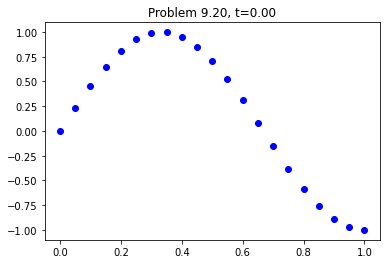

Parabolic problem, 𝜅=1
Uniform 21 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.00625 seconds


In [2]:
def u_bc(x):
    return 0.0

def u_init(x):
    return np.sin(3*np.pi*x/2)

test = Grid(21)
test.generate()
test.set_Delta_t(5.0)
test.set_Neumann_bc('right')
test.set_Dirichlet_bc('left',u_bc)
test.initial_conditions(u_init)
test.plot('Problem 9.20')
print(test)

## The Crank-Nicholson scheme
Because the scheme is implicit we need to assemnble and solve a matrix system where the left hand side is made up of a coefficient matrix multiplied by the unknown solution at the new time level, and the left hand side is made up of a coefficient matrix multiplied by the solution at the current time level and any boundary conditions.  Effectively we have:

$$A\mathbf{x}^{n+1}=B\mathbf{x}^{n}+\mathbf{b}_{bc}.$$

The coefficient matricies A and B are constant and tri-diagonal.  So we can assemble these as sparse matricies when we are setting up the problem and gnerating the grid. 

The coeeficients of the A matrix, for all internal points,  are:
$$a_{i-1,i} = -r_x,\ a_{i,i}=2+2r_x\ \mathrm{and}\ a_{i+1,i}= -r_x$$
and the coefficients of the B matrix are:
$$b_{i-1,i} = r_x,\ b_{i,i}=2-2r_x\ \mathrm{and}\ b_{i+1,i}= r_x$$

When we have a Dirichlet boundary condition then $$r_x x_i^{n+1}$$ is known and will appear in the RHS vector (in __b__<sub>bc</sub>).  If we have a Neumann boundary condition then the coefficient of _a<sub>i-1,i</sub>_ or  _a<sub>i+1,i</sub>_ is zero and the cofficient of _a<sub>i+1,i</sub>_ or _a<sub>i-1,i</sub>_ is doubled, because
$$\frac{\partial T}{\partial x}=0 \implies T_{i-1} = T_{i+1}$$




In [3]:
# Matrix assembly, we will use the same techniques as were used in the BiCGStab workbook
import scipy.sparse as sps

class Implicit(Grid):
    def assemble_matrix(self):
        '''Assemble the A and B matricies needed by the implcit solver.
        the ends of the u vector contain the boundary conditions so we 
        are only solving for the values in u[1:-1].   Because we are
        using spsolve we need to use CSR matrix format as it won't work
        with the more efficient LEL format.'''
        
        # Create the A and B matricies, remember that u[0] and u[-1] contain boundary condition values.
        self.A_mat = sps.csr_matrix((self.N_i-2, self.N_i-2), dtype=np.float64)
        self.B_mat = sps.csr_matrix((self.N_i-2, self.N_i-2), dtype=np.float64)
        
        # Calculate Rx
        Rx = self.kappa*self.Delta_t/self.Delta_x()**2

        for i in range(0,self.N_i-2):
            # Coefficients of the A Matrix
            self.A_mat[i,i] = 2 + 2 * Rx
            if i == 0:
                if self.BC[0]==self.NEUMANN_BC:
                    self.A_mat[i,i+1] = - 2 * Rx
                else:
                    self.A_mat[i,i+1] = - Rx
            elif i==self.N_i-3:
                if self.BC[1]==self.NEUMANN_BC:
                    self.A_mat[i,i-1] = - 2 * Rx
                else:
                    self.A_mat[i,i-1] = - Rx
            else:
                self.A_mat[i,i-1] = - Rx
                self.A_mat[i,i+1] = - Rx
                
            # Coefficients of the B Matrix
            self.B_mat[i,i] = 2 - 2 * Rx
            if i == 0:
                if self.BC[0]==self.NEUMANN_BC:
                    self.B_mat[i,i+1] = 2 * Rx
                else:
                    self.B_mat[i,i+1] = Rx
            elif i==self.N_i-3:
                if self.BC[1]==self.NEUMANN_BC:
                    self.B_mat[i,i-1] = 2 * Rx
                else:
                    self.B_mat[i,i-1] = Rx
            else:
                self.B_mat[i,i-1] = Rx
                self.B_mat[i,i+1] = Rx
        return Rx

/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


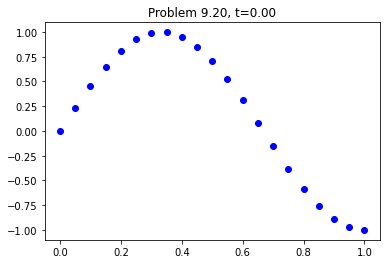

Parabolic problem, 𝜅=1
Uniform 21 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.00625 seconds


In [4]:
test = Implicit(21)
test.generate()
test.set_Delta_t(5.0)
test.set_Neumann_bc('right')
test.set_Dirichlet_bc('left',u_bc)
test.initial_conditions(u_init)
test.assemble_matrix()
test.plot('Problem 9.20')
print(test)

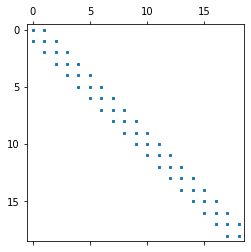

In [5]:
plt.spy(test.A_mat, markersize=2, aspect='equal')
plt.show()

### The solver
Each time step we need to:
1. Extract the interior points of the T array into the ___x___<sup>n</sup> vector
2. Assemble the RHS vector, $$\mathbf{b}=B\mathbf{x}^{n}+\mathbf{b}_{bc}$$
3. Solve $$A\mathbf{x}^{n+1}=\mathbf{b}$$
4. Unpack ___x___<sup>n+1</sup> into the T array

We have choices about how to solve A ___x___ = ___b___ we could use the Thomas algorithm as the matrix is tri-diagonal, or we can use a sparse matrix solver.

In [6]:
import scipy.sparse.linalg as LA

def Crank_Nicholson(grid):
    '''perform one time step using the Crank-Nicholson scheme on
    the parabolic problem defined by grid. In this case grid must
    be an object of the Implicit(Grid) type.'''
    
    # calculate Rx
    Rx = grid.kappa*grid.Delta_t/grid.Delta_x()**2
    
    # extract the x^n vector
    x = grid.u[-1].copy()
    
    # calculate the b vector
    b = grid.B_mat @ x[1:-1]
    
    # apply any boundary conditions to b
    if grid.BC[0] == grid.DIRICHLET_BC:
        b[0] = b[0] + Rx * x[0]
        
    if grid.BC[1] == grid.DIRICHLET_BC:
        b[:] = b[:] + Rx * x[:]
    
    # solve Ax = b, we are going to use the current values of x as an initial guess
    x_new = LA.spsolve(grid.A_mat,b)
    
    # update x
    x[1:-1] = x_new.copy()
    
    return x

Integratung to 0.1 seconds Δt=0.00625 :#########. 


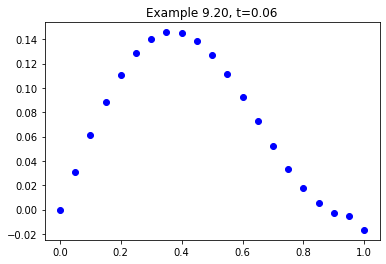

Parabolic problem, 𝜅=1
Uniform 21 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
10 time steps from t=0.0 to t=0.0563, Δt=0.00625 seconds


In [7]:
test.integrate(0.1, Crank_Nicholson)
test.plot('Example 9.20')
print(test)



/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=1.95e-05 :#########. 


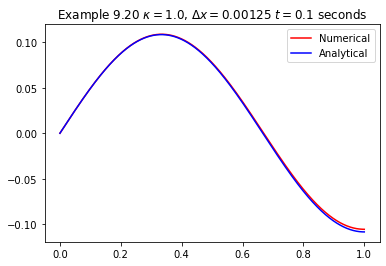

In [8]:
# finer grid, bigger Courant number
test = Implicit(801)
test.generate()
test.set_Delta_t(25.0)
test.set_Neumann_bc('right')
test.set_Dirichlet_bc('left',u_bc)
test.initial_conditions(u_init)
test.assemble_matrix()
test.integrate(0.1, Crank_Nicholson)
plt.plot(test.x,test.u[-1],'r-',label='Numerical')
u_exact = np.exp(-9*test.kappa*np.pi**2*test.t[-1]/4)*np.sin(1.5*np.pi*test.x)
plt.plot(test.x,u_exact,'b-',label='Analytical')
plt.title('Example 9.20 $\kappa=1.0$, $\Delta x={:.3g}$ $t=0.1$ seconds'.format(test.Delta_x()))
plt.legend()
plt.show()



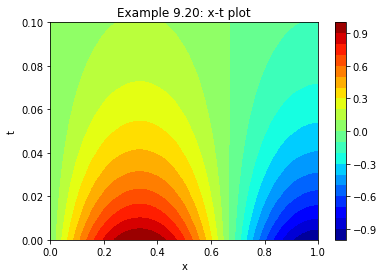

In [9]:
# X-T plot
X,T = np.meshgrid(test.x,test.t)
fig, ax1 = plt.subplots()
cmap = plt.get_cmap('jet')
cf = ax1.contourf(X,T,test.u,cmap=cmap, levels = 21)
fig.colorbar(cf, ax=ax1)
ax1.set_title('Example 9.20: x-t plot')
ax1.set_xlabel('x')
ax1.set_ylabel('t')
plt.show()


## Mesh refinement study
In this case we are going to use the range of _u(x)_ as the integrating quantity.

$$\text{Range}(u)=\max_i u - \min_i u$$

We will run the solution to _t_=0.1 seconds and use 𝜅=1.0  As with the Laplace Solvers I'm going to use a sequence of grids with

$$N_i = 20\times2^n + 1 \ n=1 \ldots 8.$$

The finest grid will have 5121 grid points and the coarsest 81.  The finest grid will take about 5 mins to run.  We are also going to plot the solution on every grid (together with the analytical solution).  

Parabolic problem, 𝜅=1
Uniform 5121 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=4.77e-07 seconds


/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=4.77e-07 :#########. 
The solver took  0:07:12.165442
Range(u) is  0.21669306086155143 



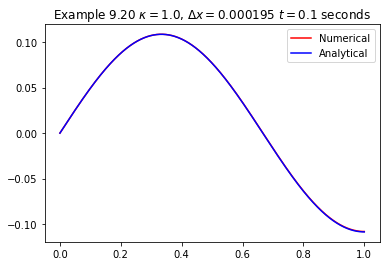

Parabolic problem, 𝜅=1
Uniform 2561 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=1.91e-06 seconds


/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=1.91e-06 :#########. 
The solver took  0:00:58.209020
Range(u) is  0.21631561822921747 



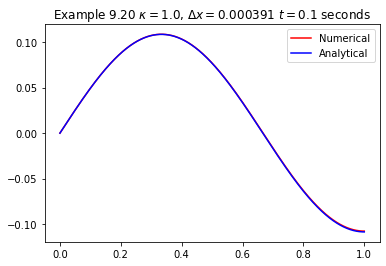

Parabolic problem, 𝜅=1
Uniform 1281 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=7.63e-06 seconds


/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=7.63e-06 :#########. 
The solver took  0:00:09.110858
Range(u) is  0.21554010881120633 



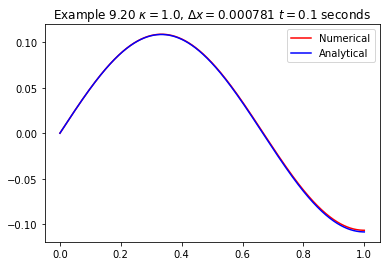

Parabolic problem, 𝜅=1
Uniform 641 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=3.05e-05 seconds


/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=3.05e-05 :#########. 
The solver took  0:00:01.950320
Range(u) is  0.21407219314960352 



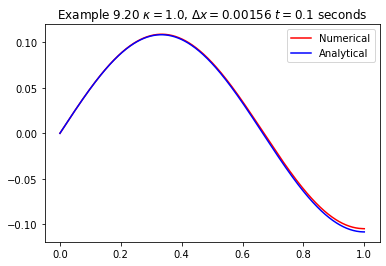

Parabolic problem, 𝜅=1
Uniform 321 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.000122 seconds


/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=0.000122 :#########. 
The solver took  0:00:00.655823
Range(u) is  0.21080799352510865 



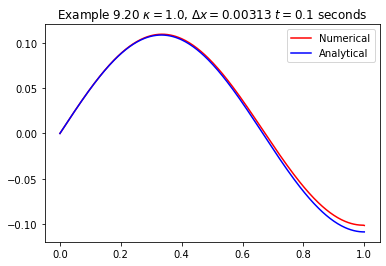

Parabolic problem, 𝜅=1
Uniform 161 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.000488 seconds


/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Integratung to 0.1 seconds Δt=0.000488 :#########. 
The solver took  0:00:00.269373
Range(u) is  0.20559063829364158 



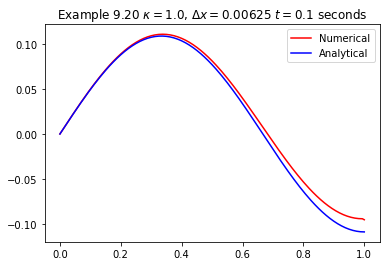

Parabolic problem, 𝜅=1
Uniform 81 node grid from 0.0 to 1.0.
Boundaries conditions are - left: Dirichlet, right: Neumann.
Initial conditions at t=0.0, Δt=0.00195 seconds
Integratung to 0.1 seconds Δt=0.00195 :#########. 
The solver took  0:00:00.135081
Range(u) is  0.1900074258372092 



/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


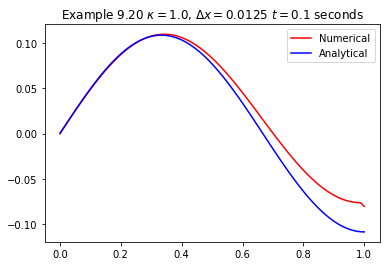

In [10]:
import datetime # just seconds may not be enough

# we need some lists u and dx values
U_val = []
dx_val = []
run_time = []
n_pts =[]
for grid_index in range(8,1,-1):
    ni = 20 * 2**grid_index + 1
    n_pts.append(ni)
    
    # set up the problem
    test = Implicit(ni)
    test.generate()
    test.set_Delta_t(25.0)
    test.set_Neumann_bc('right')
    test.set_Dirichlet_bc('left',u_bc)
    test.initial_conditions(u_init)
    print(test)
    
    # run the solver
    start = time.process_time()
    test.assemble_matrix()
    test.integrate(0.1, Crank_Nicholson)
    stop = time.process_time()
    elapsed = datetime.timedelta(seconds=stop-start)
    print("The solver took ",elapsed)

    # save dx and the range into the list for evalutation
    dx_val.append(test.Delta_x())
    U_val.append(np.max(test.u[-1])-np.min(test.u[-1]))
    run_time.append(stop-start)
        
    print('Range(u) is ',U_val[-1],'\n')    

    # plot a graph of the solution and the analytical solution on the same grid.
    plt.plot(test.x,test.u[-1],'r-',label='Numerical')
    u_exact = np.exp(-9*test.kappa*np.pi**2*test.t[-1]/4)*np.sin(1.5*np.pi*test.x)
    plt.plot(test.x,u_exact,'b-',label='Analytical')
    plt.title('Example 9.20 $\kappa=1.0$, $\Delta x={:.3g}$ $t=0.1$ seconds'.format(test.Delta_x()))
    plt.legend()
    plt.show()



Refinement Analysis on 7 grids.

Grid Delta x ratio  range(u)
----------------------------
   1 0.0001953     2  0.216693
   2 0.0003906     2  0.216316
   3 0.0007813     2   0.21554
   4 0.001563     2  0.214072
   5 0.003125     2  0.210808
   6 0.00625     2  0.205591
   7  0.0125   ---  0.190007
---------------------------- 

order of convergence, p =   1.04

Grids       GCI
---------------
 1  2  0.002064
 2  3  0.004249
 3  4  0.008072
 4  5   0.01807
 5  6   0.02933
 6  7   0.08984
---------------

 Grid Step  GCI Ratio Converged
-------------------------------
 1 2  2 3      0.9983 True
 2 3  3 4       1.082 False
 3 4  4 5      0.9177 False
 4 5  5 6       1.266 False
 5 6  6 7      0.6709 False
-------------------------------



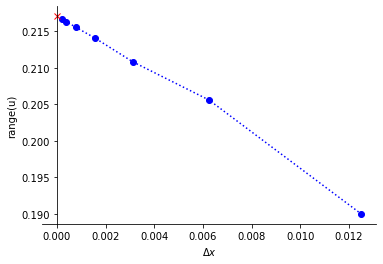

In [11]:
# now run the mesh refinement analysis
from refinement_analysis import refinement_analysis
# lets to the refinement analysis
analysis = refinement_analysis(dx_val,U_val)
analysis.report('range(u)')
analysis.plot(True,'range(u)')


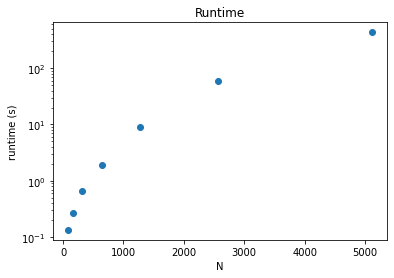

In [12]:
# plot the runtime
plt.plot(n_pts,run_time,'o')
plt.title('Runtime')
plt.xlabel('N')
plt.yscale('log',base=10) 
plt.ylabel('runtime (s)')
plt.show()